In [27]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đường dẫn thư mục chứa dữ liệu
data_dir = "MathQA"
files = ['train.json', 'test.json', 'dev.json', 'challenge_test.json']

# Đọc toàn bộ dữ liệu từ các file JSON vào DataFrame
def load_json_data(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return pd.json_normalize(json.load(f))
# Nạp dữ liệu
datasets = {fname.replace('.json', ''): load_json_data(os.path.join(data_dir, fname)) for fname in files}


Giải thích sơ về bộ dữ liệu:
- Problem: câu hỏi toán bằng ngôn ngữ tự nhiên
- Rationable: lời giải hoặc diễn giải bằng văn bản cách giải
- Options: danh sách các phương án trả lời (a,b,c,d,e)
- Correct: hãn đáp án đúng (ví dụ: c)
- Annotated_formula: công thức toán có cấu trúc, biểu diễn quá trình tính toán để đi đến kết quả
- Linear_formula: Dạng tuyến tính của công thức, biểu diễn quá trình tính toán theo từng bước
- Category: Nhóm bài toán


Giải thích vai trò các tập dữ liệu:
- train: dùng để huấn luyện mô hình
- dev: dùng để điều chỉnh tham số mô hình và chọn mô hình tốt nhất
- test: đánh giá cuối cùng hiệu quả của mô hình sau khi đã huấn luyện, tinh chỉnh
- challenge_test: kiểm tra mô hình trên những trường hợp đặc biệt hoặc khó hơn so với test thường

In [28]:
# Hiển thị số lượng mẫu và các cột
for name, df in datasets.items():
    print(f"\nDataset: {name}")
    print(f"Số lượng mẫu: {len(df)}")
    print(f"Các cột: {df.columns.tolist()}")

# Tạo một cột mới: length_problem, length_rationale để phân tích độ dài
for df in datasets.values():
    df['len_problem'] = df['Problem'].apply(len)
    df['len_rationale'] = df['Rationale'].apply(len)
    df['len_formula'] = df['annotated_formula'].apply(lambda x: len(str(x)))

# ----------PHÂN TÍCH CATEGORY ----------
def plot_category_distribution():
    plt.figure(figsize=(12, 6))
    for i, (name, df) in enumerate(datasets.items(), 1):
        plt.subplot(2, 2, i)
        sns.countplot(data=df, x='category', order=df['category'].value_counts().index)
        plt.title(f'Phân phối category - {name}')
        plt.xlabel('Category')
        plt.ylabel('Số lượng')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ----------PHÂN TÍCH ĐỘ DÀI ----------
def plot_length_distributions():
    for length_col in ['len_problem', 'len_rationale', 'len_formula']:
        plt.figure(figsize=(12, 6))
        for name, df in datasets.items():
            sns.kdeplot(df[length_col], label=name)
        plt.title(f'Distribution: {length_col}')
        plt.xlabel('Length')
        plt.legend()
        plt.grid(True)
        plt.show()

# ----------TỶ LỆ NHÃN ĐÚNG ----------
def plot_label_distribution():
    for name, df in datasets.items():
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x='correct', order=sorted(df['correct'].unique()))
        plt.title(f'Phân phối nhãn đúng (correct) - {name}')
        plt.xlabel('Lựa chọn đúng')
        plt.ylabel('Số lượng')
        plt.grid(True)
        plt.show()

# ----------PHÂN TÍCH FORMULA ----------
def analyze_formulas():
    all_operators = []
    for name, df in datasets.items():
        for formula in df['annotated_formula']:
            for op in ['add', 'subtract', 'multiply', 'divide', 'power']:
                if op in formula:
                    all_operators.append(op)
    op_series = pd.Series(all_operators).value_counts()
    op_series.plot(kind='barh', title='Phân phối các toán tử trong annotated_formula', figsize=(8, 5))
    plt.xlabel('Số lần xuất hiện')
    plt.grid(True)
    plt.show()


Dataset: train
Số lượng mẫu: 29837
Các cột: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category']

Dataset: test
Số lượng mẫu: 2985
Các cột: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category']

Dataset: dev
Số lượng mẫu: 4475
Các cột: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category']

Dataset: challenge_test
Số lượng mẫu: 604
Các cột: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category']


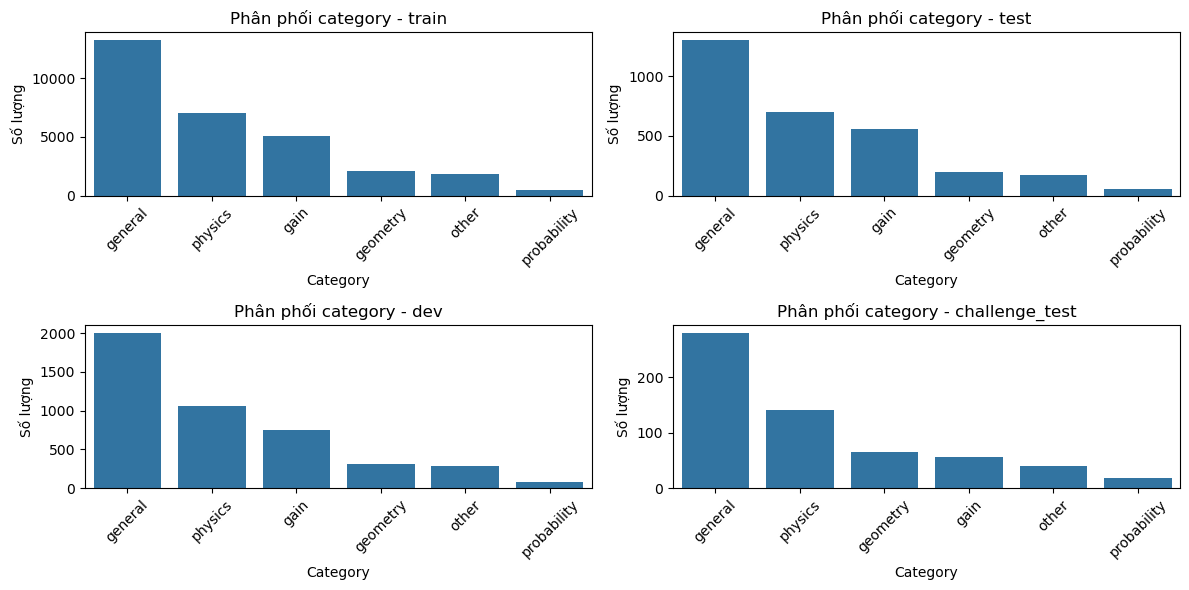

In [29]:
plot_category_distribution()

Biểu đồ phân phối các danh mục bài toán trong 4 tập dữ liệu (train, test, dev, challenge_test) cho thấy:

- Danh mục "general" chiếm số lượng lớn nhất trong tất cả các tập (khoảng 10.000 ở train, 2.000 ở test/dev, 200 ở challenge_test).
- "Physics", "gain", "geometry" có số lượng giảm dần, với "physics" khoảng 5.000 (train), "geometry" và "gain" dưới 2.000.
- "Other" và "probability" rất ít, dưới 1.000 ở tất cả các tập.
- Insight: Tập dữ liệu tập trung vào bài toán "general", ít bài toán về xác suất ("probability") và các loại khác ("other"), phù hợp với mục tiêu học toán tổng quát.

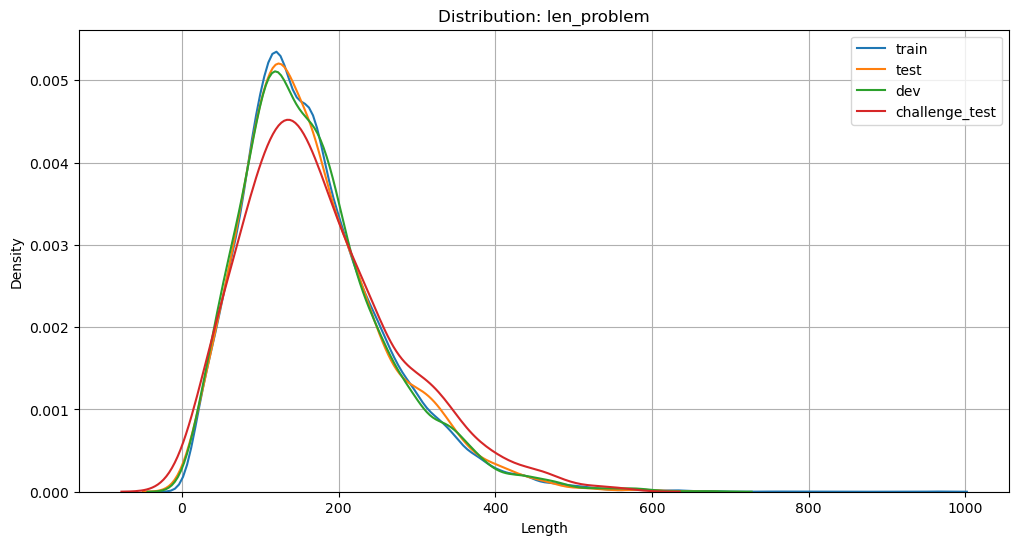

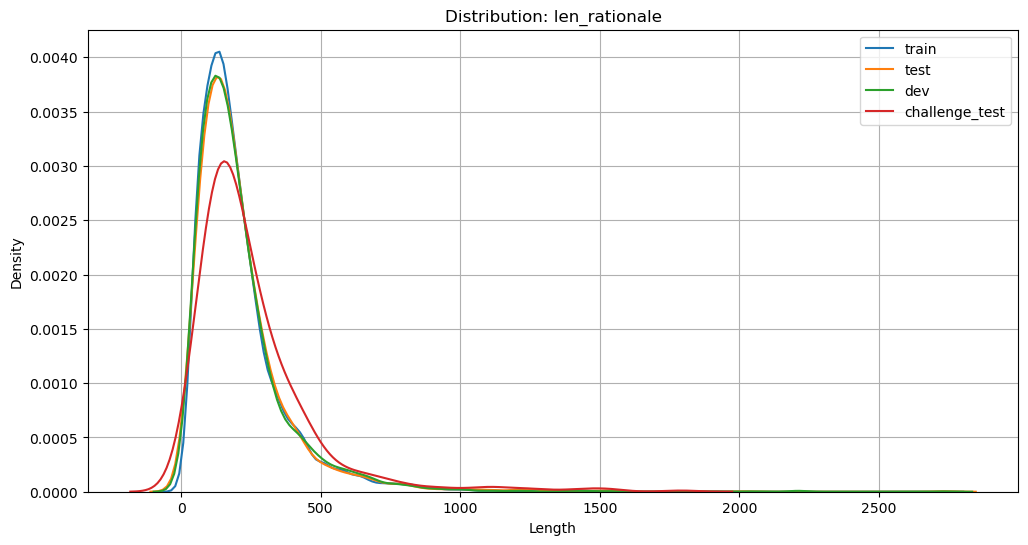

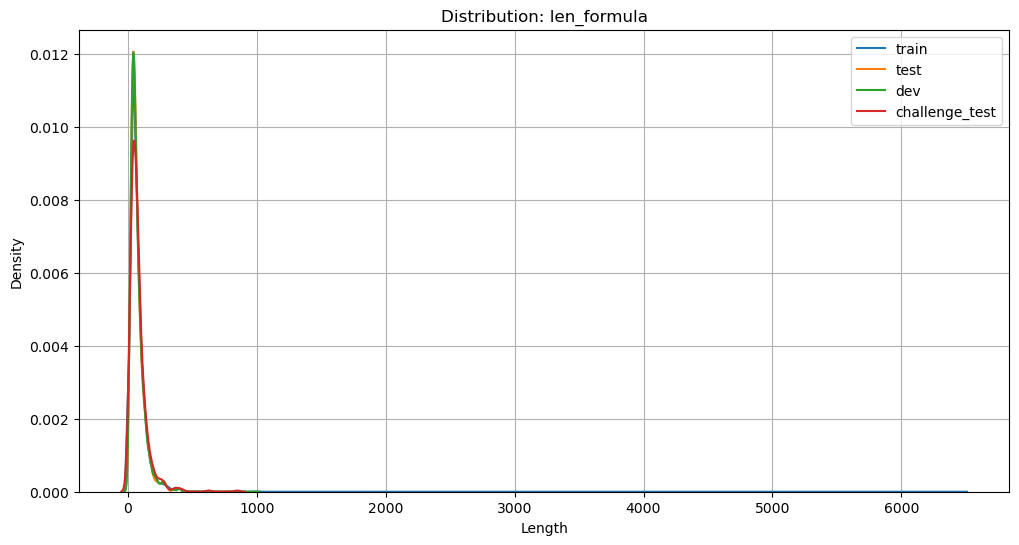

In [30]:
plot_length_distributions()

Biểu đồ "Distribution: len_problem"
- Phân phối độ dài câu hỏi (len_problem) trong các tập train, test, dev, challenge_test có đỉnh cao nhất ở khoảng 0-200, giảm dần sau đó.
- Tất cả các tập có xu hướng tương đồng, với đa số độ dài dưới 400, và rất ít vượt quá 1.000.
- Insight: Câu hỏi chủ yếu ngắn gọn, tập trung vào các bài toán đơn giản, phù hợp với cấp tiểu học.

Biểu đồ "Distribution: len_rationale"
- Phân phối độ dài giải thích (len_rationale) cũng đạt đỉnh ở khoảng 0-500, giảm mạnh sau 1.000.
- Tập challenge_test có đuôi dài hơn (lên đến 2.500), cho thấy giải thích phức tạp hơn.
- Insight: Giải thích thường ngắn, nhưng bài toán thử thách có thể yêu cầu suy luận dài hơn.

Biểu đồ "Distribution: len_formula"
- Phân phối độ dài công thức (len_formula) tập trung ở khoảng 0-1.000, với train và challenge_test cao nhất tại đầu.
- Rất ít công thức vượt quá 2.000, và gần như không có ở độ dài lớn.
- Insight: Công thức thường ngắn gọn, tập trung vào các phép tính cơ bản, với dữ liệu thử thách có phần đa dạng hơn.

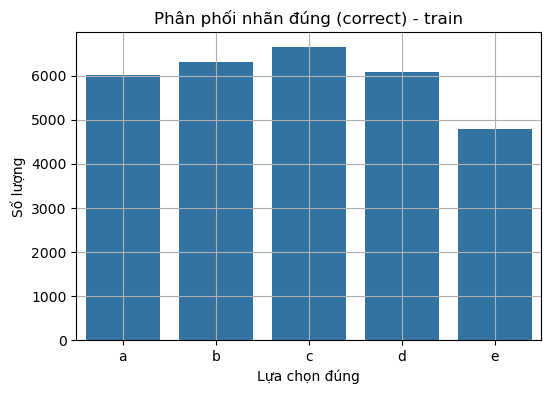

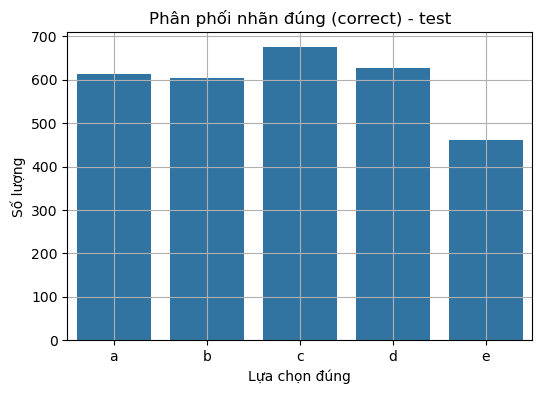

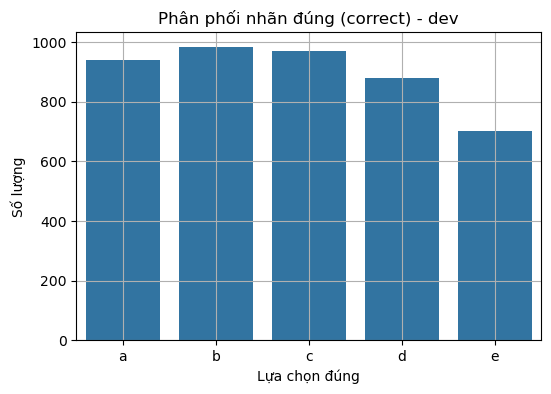

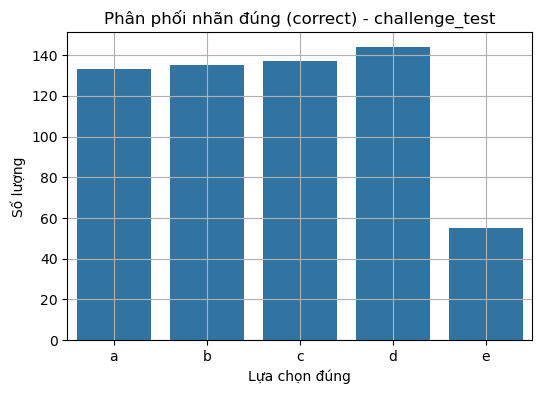

In [31]:
plot_label_distribution()

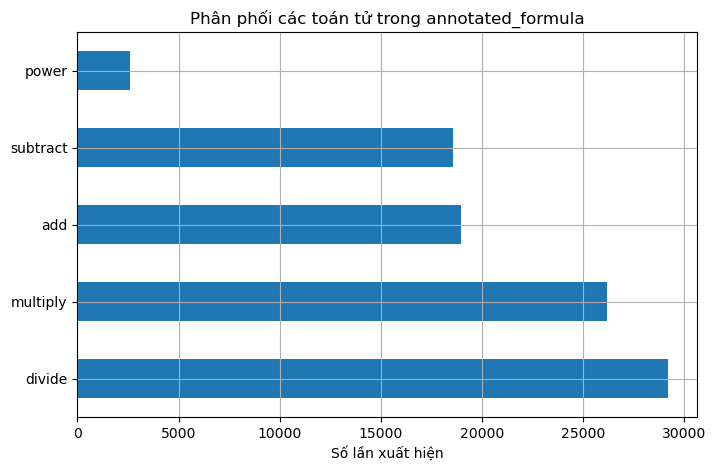

In [32]:
analyze_formulas()

Biểu đồ "Phân phối các phép toán trong annotated formula" cho thấy:
- Phép "divide" (chia) có số lần xuất hiện cao nhất (gần 3.000), tiếp theo là "multiply" (nhân) và "add" (cộng) (khoảng 2.000-2.500).
- Phép "subtract" (trừ) thấp hơn một chút (khoảng 1.500), trong khi "power" (lũy thừa) rất ít (dưới 1.000).
- Insight: Các phép toán cơ bản như chia, nhân, cộng chiếm ưu thế, trong khi lũy thừa hiếm gặp, phản ánh tập trung vào toán tiểu học cơ bản.

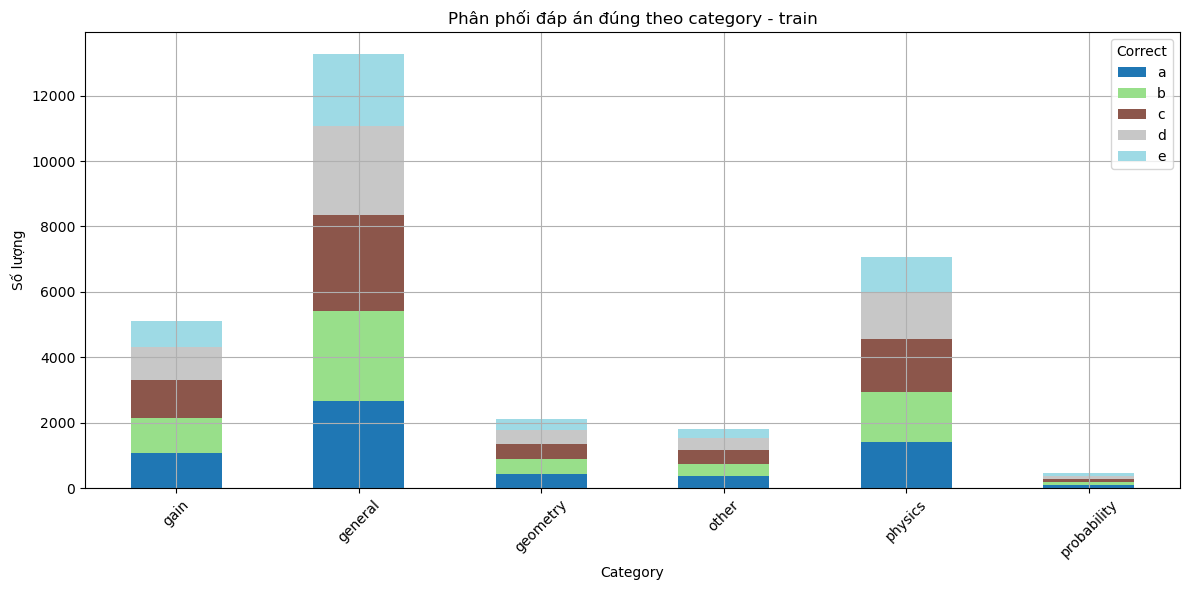

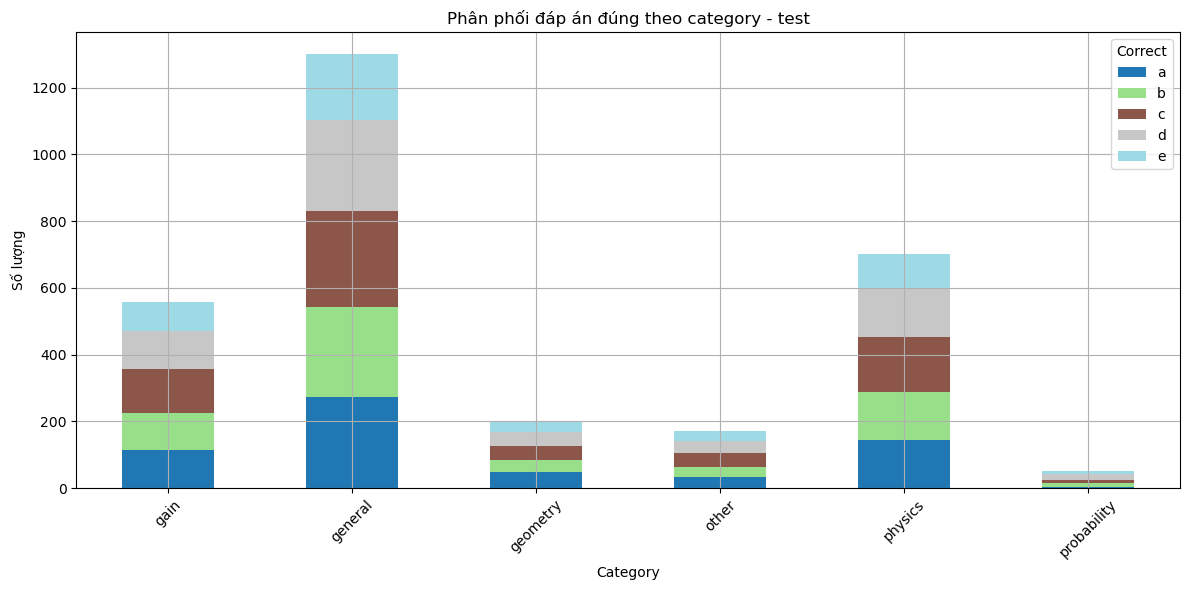

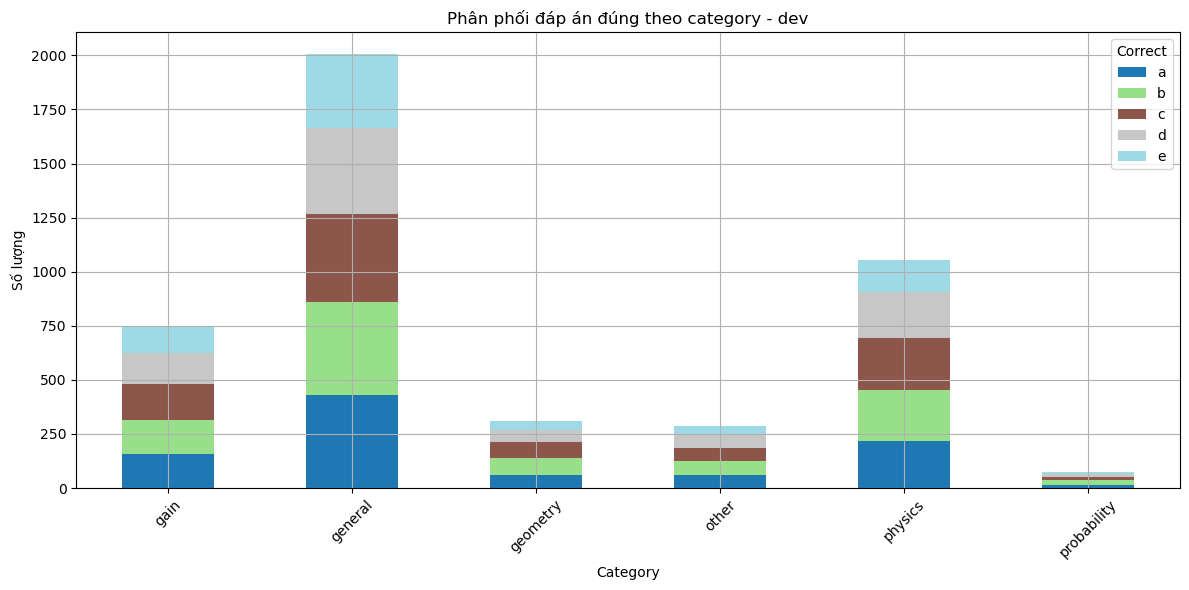

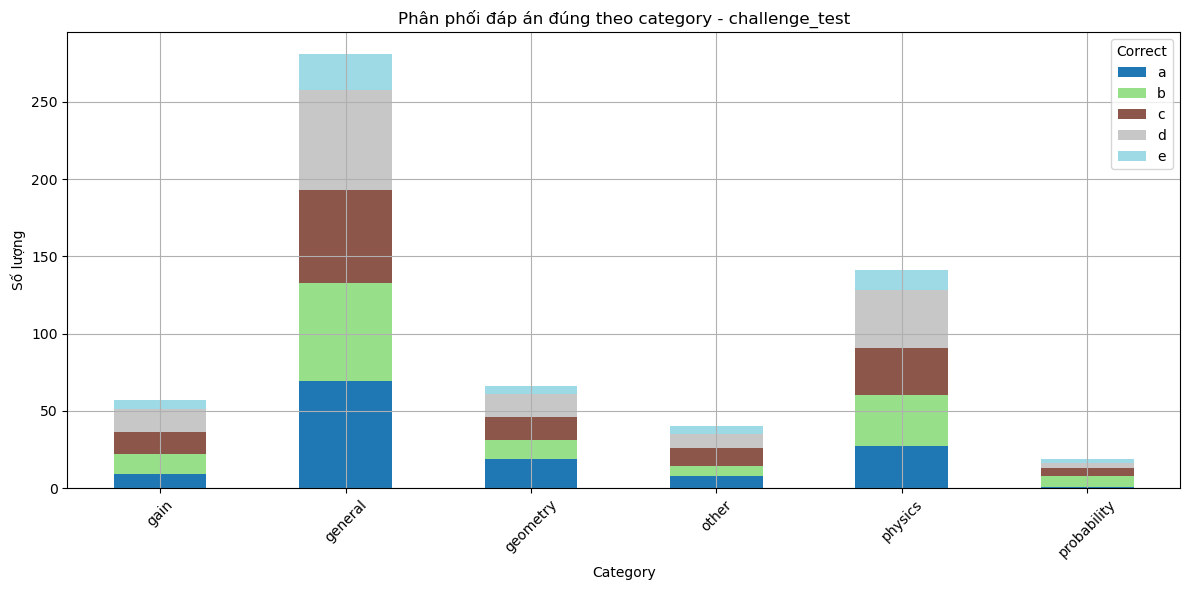

In [33]:
def correct_vs_category():
    for name, df in datasets.items():
        ct = pd.crosstab(df['category'], df['correct'])
        ct.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
        plt.title(f'Phân phối đáp án đúng theo category - {name}')
        plt.xlabel('Category')
        plt.ylabel('Số lượng')
        plt.xticks(rotation=45)
        plt.legend(title='Correct')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
correct_vs_category()

Biểu đồ "Phân phối đáp án đúng theo danh mục - train/test/dev/challenge_test" cho thấy:
- Danh mục "general" có số lượng đáp án cao nhất (khoảng 12.000-2.000 tùy tập), chủ yếu đúng (màu xanh).
- "Physics" và "gain" có số lượng đáng kể, với tỷ lệ đúng và sai (a-e) tương đối cân bằng.
- "Geometry", "other", và "probability" có số lượng thấp, với "probability" gần như không đáng kể.
- Insight: "General" là danh mục chính, tập trung nhiều đáp án đúng, trong khi các danh mục khác ít phổ biến và có sự phân bố đáp án đa dạng hơn.

In [34]:
def avg_operator_per_formula():
    for name, df in datasets.items():
        df['num_ops'] = df['annotated_formula'].apply(lambda f: sum(f.count(op) for op in ['add', 'subtract', 'multiply', 'divide', 'power']))
        avg_ops = df['num_ops'].mean()
        print(f"{name}: Trung bình {avg_ops:.2f} toán tử / công thức")

avg_operator_per_formula()

train: Trung bình 4.70 toán tử / công thức
test: Trung bình 4.65 toán tử / công thức
dev: Trung bình 4.66 toán tử / công thức
challenge_test: Trung bình 5.09 toán tử / công thức


Dựa trên các giá trị trung bình số toán tử mỗi công thức:
- Train (4.70), test (4.65), và dev (4.66) có số toán tử tương tự, cho thấy độ phức tạp đồng đều.
- Challenge_test (5.09) cao hơn rõ rệt, chỉ ra các bài toán thử thách phức tạp hơn.
- Insight: Challenge_test đòi hỏi suy luận nhiều bước hơn, phù hợp để kiểm tra khả năng giải quyết vấn đề nâng cao.

In [35]:
def option_order_match():
    for name, df in datasets.items():
        mismatches = 0
        for _, row in df.iterrows():
            try:
                options = [opt.strip()[0] for opt in row['options'].split(',')]
                if row['correct'] not in options:
                    mismatches += 1
            except:
                mismatches += 1
        print(f"{name}: {mismatches} dòng có nhãn `correct` không trùng với `options`")
option_order_match()

train: 842 dòng có nhãn `correct` không trùng với `options`
test: 66 dòng có nhãn `correct` không trùng với `options`
dev: 115 dòng có nhãn `correct` không trùng với `options`
challenge_test: 52 dòng có nhãn `correct` không trùng với `options`


Bộ dữ liệu như MathQA cần đảm bảo rằng nhãn correct (đáp án đúng) phải khớp với một trong các lựa chọn trong options. Nếu không, dữ liệu có thể bị lỗi, gây khó khăn cho việc huấn luyện mô hình học máy hoặc kiểm tra.

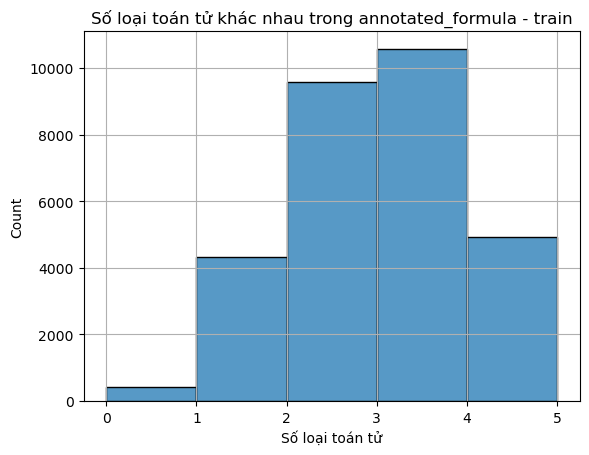

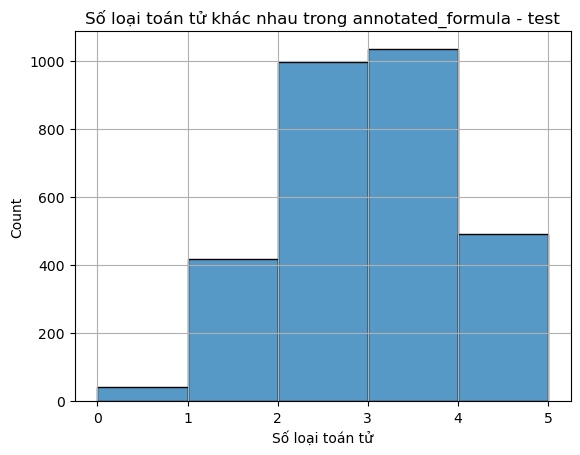

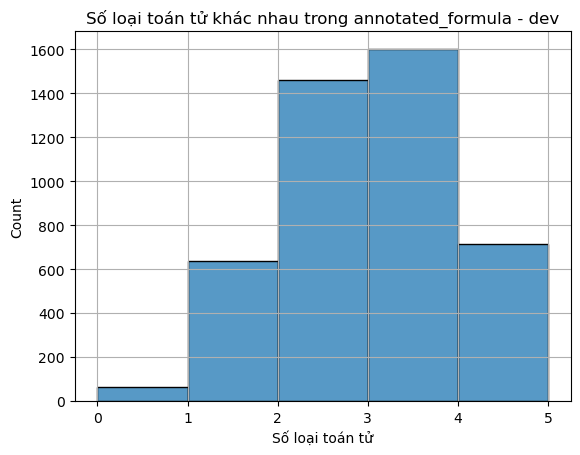

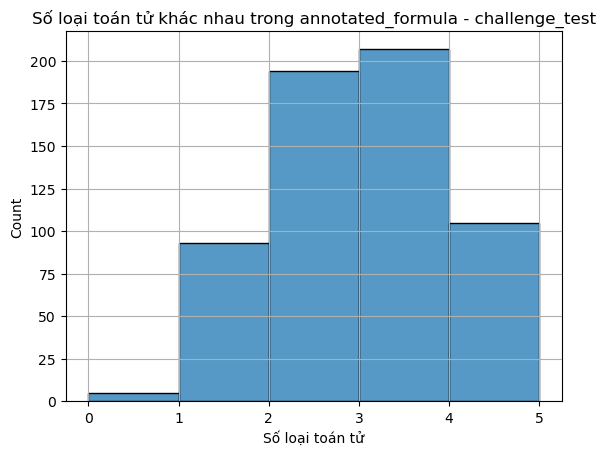

In [36]:
def operator_diversity():
    for name, df in datasets.items():
        df['unique_ops'] = df['annotated_formula'].apply(lambda f: len(set(op for op in ['add', 'subtract', 'multiply', 'divide', 'power'] if op in str(f))))
        sns.histplot(df['unique_ops'], bins=5)
        plt.title(f'Số loại toán tử khác nhau trong annotated_formula - {name}')
        plt.xlabel('Số loại toán tử')
        plt.grid(True)
        plt.show()
operator_diversity()

Biểu đồ "Số loại toán tử khác nhau trong annotated_formula" cho thấy:
- Tập train, test, dev, và challenge_test đều có phân bố tương tự, với đa số công thức chứa 2-3 loại toán tử (đỉnh cao nhất khoảng 3).
- Tập train có số lượng lớn nhất (gần 10.000), trong khi challenge_test nhỏ nhất (dưới 200).
- Số công thức chứa 0-1 hoặc 4-5 loại toán tử rất ít.
- Insight: Công thức chủ yếu sử dụng 2-3 loại toán tử, cho thấy độ đa dạng vừa phải, phù hợp với bài toán tiểu học.

In [38]:
def classify_difficulty(df):
    # Quy ước đơn giản:
    # Dễ: < 80 ký tự, <= 2 toán tử
    # Trung bình: 80-130 ký tự, <= 4 toán tử
    # Khó: > 130 ký tự hoặc >= 5 toán tử
    def label(row):
        if row['len_problem'] > 130 or row['num_ops'] >= 5:
            return 'Khó'
        elif row['len_problem'] >= 80 or row['num_ops'] >= 3:
            return 'Trung bình'
        else:
            return 'Dễ'

    df['difficulty'] = df.apply(label, axis=1)
    return df

for name in datasets:
    datasets[name] = classify_difficulty(datasets[name])
    print(f"\n{name} - Phân phối độ khó:")
    print(datasets[name]['difficulty'].value_counts())



train - Phân phối độ khó:
difficulty
Khó           21121
Trung bình     6623
Dễ             2093
Name: count, dtype: int64

test - Phân phối độ khó:
difficulty
Khó           2095
Trung bình     695
Dễ             195
Name: count, dtype: int64

dev - Phân phối độ khó:
difficulty
Khó           3161
Trung bình     985
Dễ             329
Name: count, dtype: int64

challenge_test - Phân phối độ khó:
difficulty
Khó           455
Trung bình    116
Dễ             33
Name: count, dtype: int64


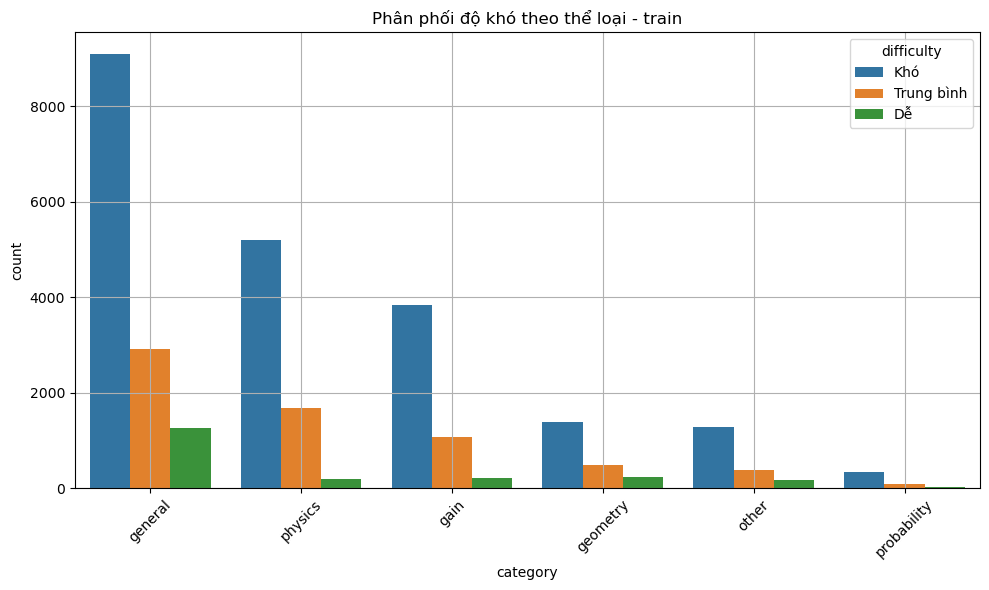

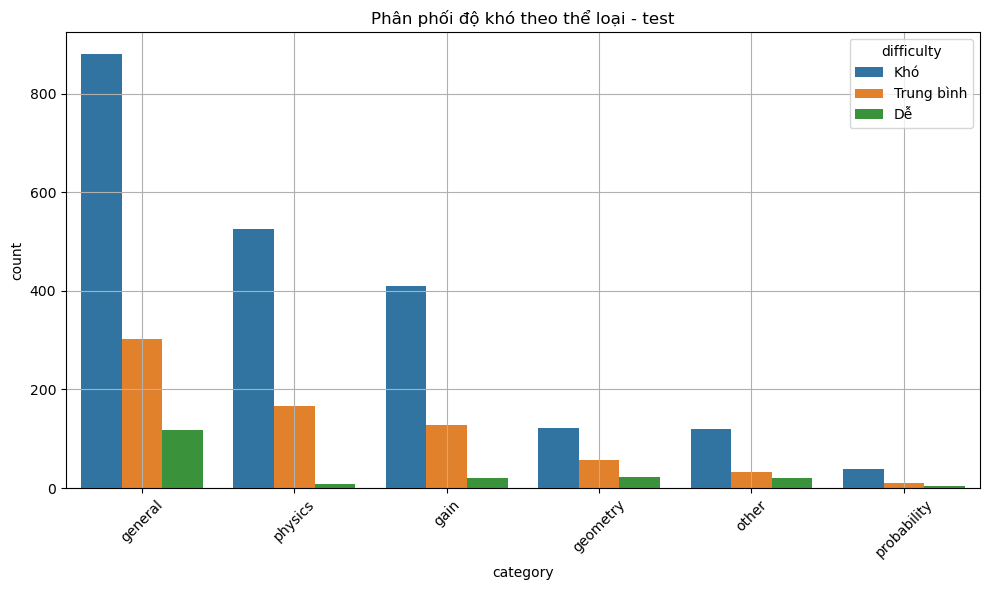

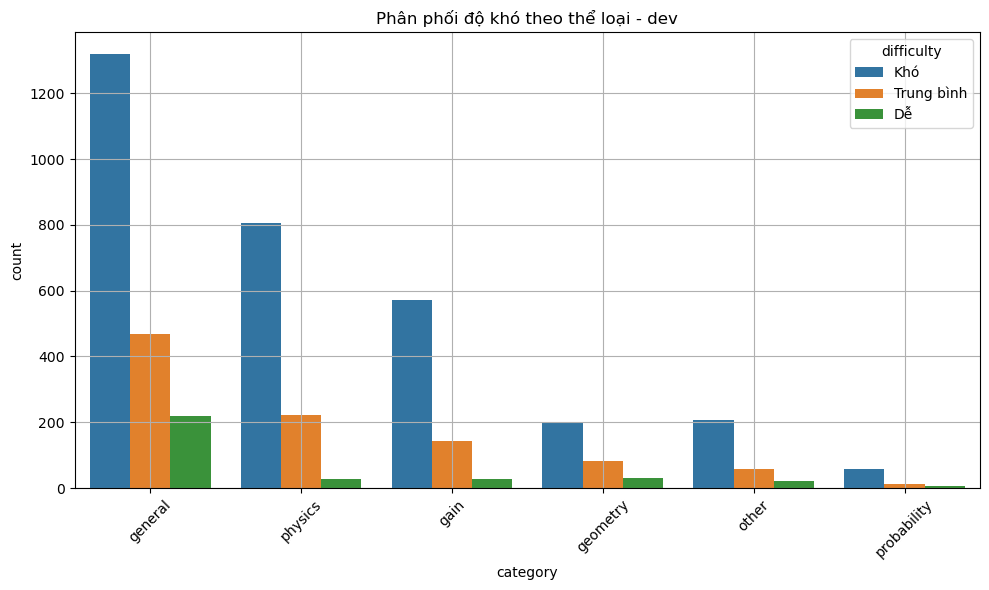

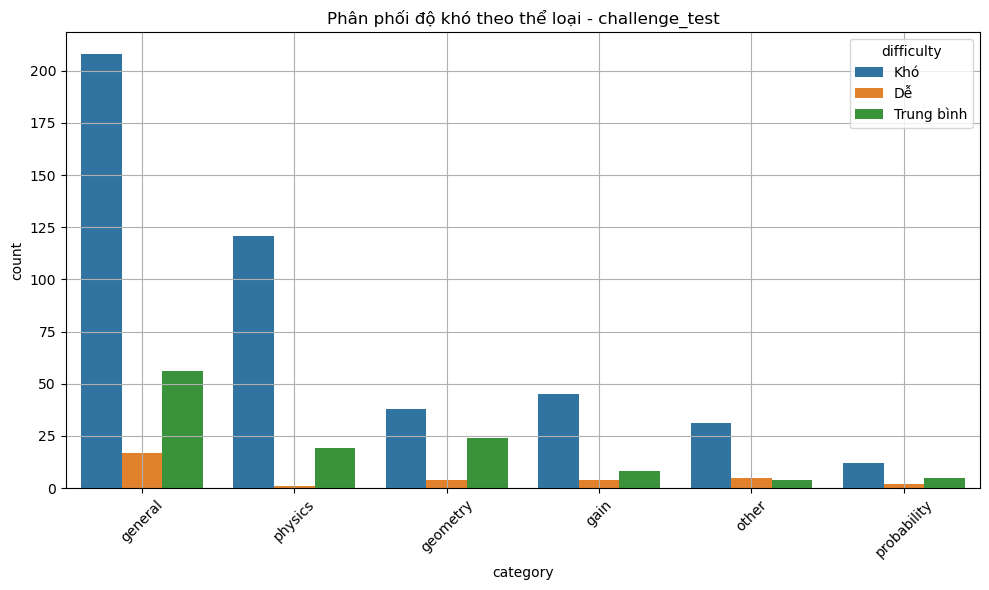

In [39]:
def difficulty_vs_category():
    for name, df in datasets.items():
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x='category', hue='difficulty', order=df['category'].value_counts().index)
        plt.title(f'Phân phối độ khó theo thể loại - {name}')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
difficulty_vs_category()

Biểu đồ "Phân phối độ khó theo danh mục - train/test/dev/challenge_test" cho thấy:
- Danh mục "general" luôn có số lượng lớn nhất (khoảng 8.000-200 tùy tập), với độ khó "khó" (màu xanh) chiếm ưu thế, tiếp theo là "trung bình" (cam) và "dễ" (xanh lá).
- "Physics" và "gain" có số lượng đáng kể, với "khó" và "trung bình" phổ biến.
- Các danh mục "geometry", "other", "probability" có số lượng thấp, chủ yếu là "khó" và "trung bình".
- Insight: "General" là danh mục chính với độ khó đa dạng, trong khi các danh mục khác ít phổ biến và tập trung vào độ khó cao hơn.